### ex4.1

In [2]:
import pulp
import networkx
import matplotlib.pyplot as plt

$n$: # of vertices  
$M = n+1$: big-M  
$x_{ij}, 0 \leq i, j < n \iff \text{node i has color j}$
として、
\begin{align}
\min & \sum_{i,j}{x_{ij}} * (M ^ j) \\
\text{s.t.} & \sum_j x_{ij}  = 1, & 0 \leq i < n \\
 & x_{uj} + x_{vj} \leq 1, & 0 \leq j < n, (u,v) \in G \\
 & x_{ij} \in \{0, 1\}, & 0 \leq i,j < n\\
\end{align}



In [3]:
import math
import re
def prob1(n, edges):
    M = n + 1
    prob = pulp.LpProblem('prob1', pulp.LpMinimize)
    xs = pulp.LpVariable.dicts('x', (range(n), range(n)), cat=pulp.LpBinary)

    prob += pulp.lpSum([(M ** j) * xs[i][j] for i in range(n) for j in range(n)])

    for u in range(n):
        prob += (pulp.lpSum([xs[u][c] for c in range(n)]) == 1)

    for u, v in edges:
        for c in range(n):
            prob += (xs[u][c] + xs[v][c] <= 1)
    return prob, M

def get_assign_and_pprint_prob1(p: pulp.LpProblem, M: int):
    print(f'status {pulp.LpStatus[p.status]}')
    if p.status != pulp.LpStatusOptimal:
        return {}
    objective = pulp.value(p.objective)
    print(f'objective {objective}, color {math.ceil(math.log(objective, M))}')
    assign = {}
    for v in p.variables():
        if pulp.value(v) == 1:
            m = re.match('.*_(\d)+_(\d)', str(v))
            assign[int(m[1])] = int(m[2])
    print(assign)
    return assign

p,M = prob1(3, [(0,1), (1,2)])
p.solve(pulp.PULP_CBC_CMD(msg=0))
get_assign_and_pprint_prob1(p,M)

status Optimal
objective 6.0, color 2
{0: 0, 1: 1, 2: 0}


{0: 0, 1: 1, 2: 0}

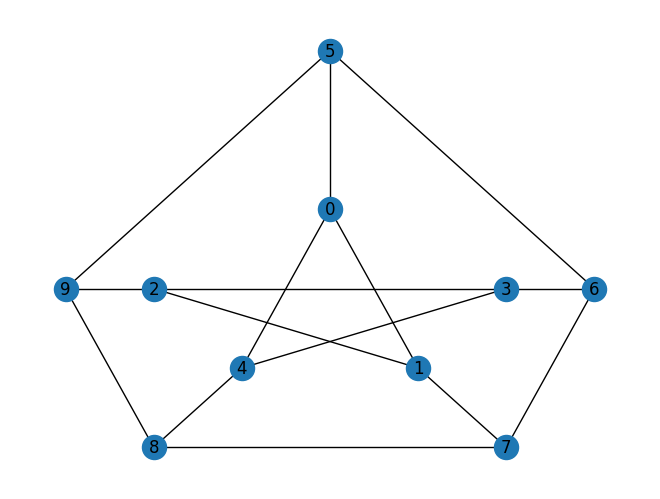

In [4]:
edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 0],
        [5, 6], [6, 7], [7, 8], [8, 9], [9, 5],
        [0, 5], [1, 7], [2, 9], [3, 6], [4, 8]]
pos = {0: (50, 50), 1: (60, 30), 2: (30, 40), 3: (70, 40), 4: (40, 30), 
       5: (50, 70), 6: (80, 40), 7: (70, 20), 8: (30, 20), 9: (20, 40), 
       }
G = networkx.Graph()
G.add_nodes_from(range(10))
for s, t in edges:
    G.add_edge(s, t)

networkx.draw(G, pos=pos, with_labels=True)
plt.show()

In [5]:
p,M = prob1(10, edges)
p.solve(pulp.PULP_CBC_CMD(msg=0))
assign = get_assign_and_pprint_prob1(p,M)

status Optimal
objective 400.0, color 3
{0: 2, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 2, 7: 1, 8: 0, 9: 2}


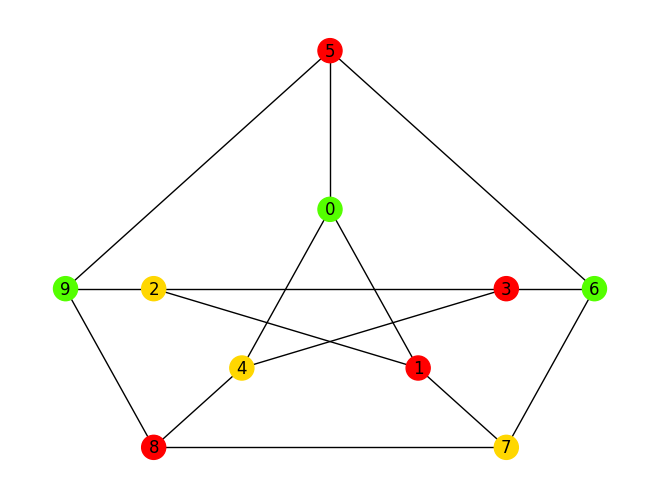

In [6]:
node_color = [assign[i] for i in range(10)]
networkx.draw(G, pos=pos, with_labels=True, node_color=node_color, cmap=plt.cm.prism)
plt.show()

### ex4.2

$n$: # of vertices  
$M$: big-M  
$x_{ij}, 0 \leq i, j < n \iff \text{edge i -> j is used}$  
$y_{i}, z_{i}$: the time when arrive/leave at city i(w/o node s)
として、
\begin{align}
\min & \sum_{i,j}{d_{ij} x_{ij}} &\\
\text{s.t.} & \sum_{0\leq j < n, j\not=i } x_{ij}  = 1, & 0 \leq i < n \\
 & \sum_{0\leq i < n, i\not=j } x_{ij}  = 1, & 0 \leq j < n \\
 & z_u + d_{uv} x_{uv} \leq y_v + M(1 - x_{uv}) , & 0 \leq u,v < n, u\not = v\\
 & y_u \leq z_u, & 0 \leq u < n, u \not= s\\
 & a_u \leq z_u, & 0 \leq u < n, u \not= s\\
 & z_s \leq y_s, & \\
 & a_u \leq y_u \leq b_u, & 0 \leq u < n, u \not = s\\
 & a_s \leq z_s \leq b_s, &\\
 & x_{ij} \in \{0, 1\} & 0 \leq i,j < n \\
 & 0 \leq y_i,z_i & 0 \leq i < n \\
\end{align}



In [7]:
import math
import re
def prob2(n, s, ds, aas, bs):
    M = sum(map(sum, ds)) + 1
    prob = pulp.LpProblem('prob2', pulp.LpMinimize)
    xs = pulp.LpVariable.dicts('x', (range(n), range(n)), cat=pulp.LpBinary)
    ys = pulp.LpVariable.dicts('y', range(n), cat=pulp.LpInteger)
    zs = pulp.LpVariable.dicts('z', range(n), cat=pulp.LpInteger)

    prob += pulp.lpSum([ds[i][j] * xs[i][j] for i in range(n) for j in range(n)])

    for i in range(n):
        prob += (pulp.lpSum([xs[i][j] for j in range(n) if i != j]) == 1)
    for j in range(n):
        prob += (pulp.lpSum([xs[i][j] for i in range(n) if i != j]) == 1)

    for u in range(n):
        for v in range(n):
            prob += (zs[u] + ds[u][v] * xs[u][v] <= ys[v] + M * (1 - xs[u][v]))
    for u in range(n):
        if u == s:
            prob += (zs[u] <= ys[u])
        else:
            prob += (ys[u] <= zs[u])
            prob += (aas[u] <= zs[u])
    for i in range(n):
        if u == s:
            prob += (aas[i] <= zs[i] <= bs[i])
        else:
            prob += (aas[i] <= ys[i] <= bs[i])
        prob += (0 <= zs[i])

    return prob, M

def get_assign_and_pprint_prob2(p: pulp.LpProblem, M: int, verbose=False):
    print(f'status {pulp.LpStatus[p.status]}')
    if p.status != pulp.LpStatusOptimal:
        return {}
    objective = pulp.value(p.objective)
    print(f'objective {objective}')
    assign = {}
    for v in p.variables():
        if verbose:
            print(f'{str(v)} is {pulp.value(v)}')
        if pulp.value(v) == 1:
            m = re.match('x_(\d)+_(\d)', str(v))
            if m is not None:
                assign[int(m[1])] = int(m[2])
    print(assign)
    return assign

In [8]:
# s=0 -> 1 -> 2 -> 4 -> 3 -> 0
N = 5
abss = [[0, 100],
[10, 15],
[22, 22],
[0, 100],
[0, 33]]
ds = [
 [ 0, 12, 20, 25, 5],
 [12,  0, 10, 11, 22],
 [20, 10,  0,  2, 11],
 [25, 11,  2,  0, 10],
 [5, 22, 11, 10,  0],
]

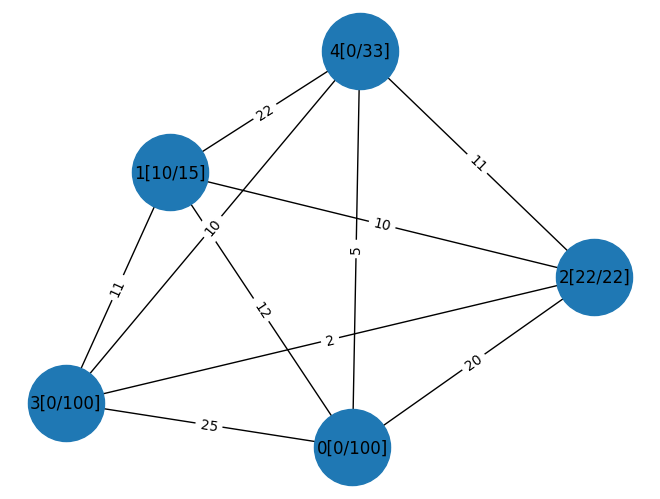

In [9]:
def draw(N, ds, abss):
    G = networkx.complete_graph(N)
    for i in range(N):
        for j in range(i):
            G.add_edge(i, j, weight=ds[i][j])
    node_labels = {}
    for i in range(N):
        node_labels[i] = f'{i}[{abss[i][0]}/{abss[i][1]}]'

    pos = networkx.spring_layout(G)
    labels = networkx.get_edge_attributes(G,'weight')
    networkx.draw(G,pos, node_size=300*10, labels=node_labels)
    networkx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

draw(N, ds, abss)

In [10]:
aas = [abss[i][0] for i in range(N)]
bs = [abss[i][1] for i in range(N)]
p,M = prob2(N, 0, ds, aas, bs)
p.solve(pulp.PULP_CBC_CMD(msg=0))
assign = get_assign_and_pprint_prob2(p, M)

status Optimal
objective 68.0
{0: 1, 1: 2, 2: 4, 3: 0, 4: 3}


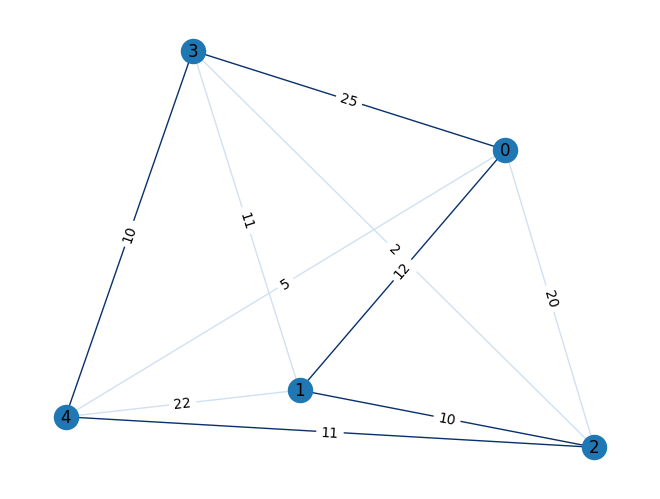

In [11]:
G = networkx.complete_graph(N)
for i in range(N):
    for j in range(N):
        if i == j: continue
        color = 5 if assign[i] == j or assign[j] == i else 1
        G.add_edge(i, j, weight=ds[i][j], color=color)

labels = networkx.get_edge_attributes(G,'weight')
colors = [edge['color'] for edge in G.edges.values()]

pos=networkx.spring_layout(G)
networkx.draw(G, pos, edge_cmap=plt.cm.Blues, edge_color=colors, edge_vmin=0, edge_vmax=5)
networkx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
networkx.draw_networkx_labels(G, pos)

plt.show()

infeasible な例

In [12]:
# node 0(t=0) -> node 1(t=1) -> (wait) node 1(t=109) -> node0 (t=110)
N = 2
abss = [
    [0, 100],
    [109, 110]]
ds = [
 [ 0, 1,],
 [ 1, 0,],
]
aas = [abss[i][0] for i in range(N)]
bs = [abss[i][1] for i in range(N)]
p,M = prob2(N, 0, ds, aas, bs)
print(p)
p.solve(pulp.PULP_CBC_CMD(msg=0))
assign = get_assign_and_pprint_prob2(p, M, True)

prob2:
MINIMIZE
1*x_0_1 + 1*x_1_0 + 0
SUBJECT TO
_C1: x_0_1 = 1

_C2: x_1_0 = 1

_C3: x_1_0 = 1

_C4: x_0_1 = 1

_C5: 3 x_0_0 - y_0 + z_0 <= 3

_C6: 4 x_0_1 - y_1 + z_0 <= 3

_C7: 4 x_1_0 - y_0 + z_1 <= 3

_C8: 3 x_1_1 - y_1 + z_1 <= 3

_C9: - y_0 + z_0 <= 0

_C10: y_1 - z_1 <= 0

_C11: z_1 >= 109

_C12: y_0 <= 100

_C13: z_0 >= 0

_C14: y_1 <= 110

_C15: z_1 >= 0

VARIABLES
0 <= x_0_0 <= 1 Integer
0 <= x_0_1 <= 1 Integer
0 <= x_1_0 <= 1 Integer
0 <= x_1_1 <= 1 Integer
y_0 free Integer
y_1 free Integer
z_0 free Integer
z_1 free Integer

status Infeasible
